In [1]:
# torch related imports
import torch
from lightning.pytorch.loggers import TensorBoardLogger

# imports for hyperparam tuning with Ray
from ray import tune
from ray.train.torch import TorchTrainer
from ray.train import RunConfig, ScalingConfig, CheckpointConfig

# Lightning
import lightning as L

from utils import loadData, plotExamples, set_reproducibility
from models import train_func, tuning, ConvNet, Classificator

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-15 15:02:31,590	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-15 15:02:32,083	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-15 15:02:32,153	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Hyperparameters

In [2]:
#Dataloader params
NUM_WORKERS = 7 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for faster init
USE_AUGMENT = False  # mutual exclusive with CUSTOM_TRAIN_VAL_SPLIT
CUSTOM_TRAIN_VAL_SPLIT = True  # mutual exclusive with USE_AUGMENT
#DATA_DIR = "chest_xray" # Change this to chest_xray folder
DATA_DIR = "/Project/chest_xray" # Change this to chest_xray folder
USE_SAMPLER = False
SHOW_ANALYTICS = False

# Lightning moduls params
EPOCHS = 50
CLASS_LABELS = ["Normal", "Pneumonia"]
NUM_CLASSES = 2

# Tuning params
NUM_SAMPLES = 20 # Number of sampls from parameter space

search_space = {
    "reproducibility_active": True,
    "epochs": EPOCHS,
    #"seed": tune.randint(0, 10000),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16,32, 64]),
    "loss" : tune.choice(["BCEwLogits", "CrossEntropyLoss"]),
    "dropout": tune.choice([0.2, 0.5, 0.8]), # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10518240/pdf/cureus-0015-00000044130.pdf
}

## Ensuring reporducibility

In [3]:
# Setting the seed
set_reproducibility(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


## Load Data and show Analytics

Size of train dataset: 4186
Size of validation dataset: 1046
Size of test dataset: 624


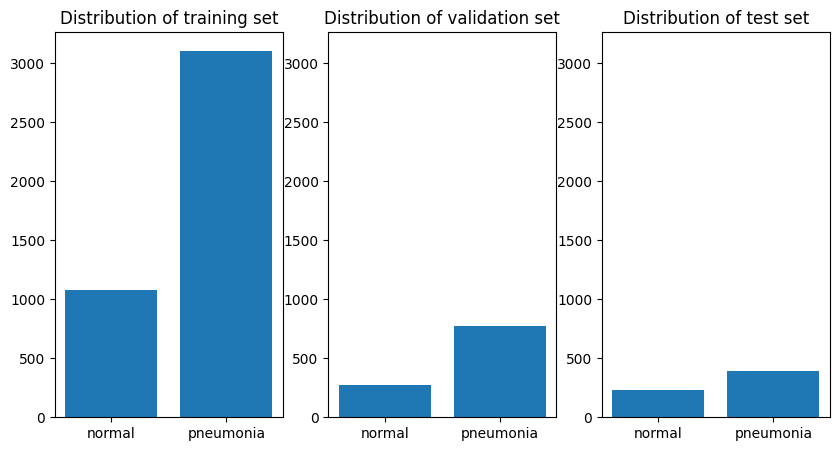

In [4]:
# show analytics
train_loader, val_loader, test_loader = loadData(numWorkers=NUM_WORKERS, showAnalytics = True, batchSize = 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


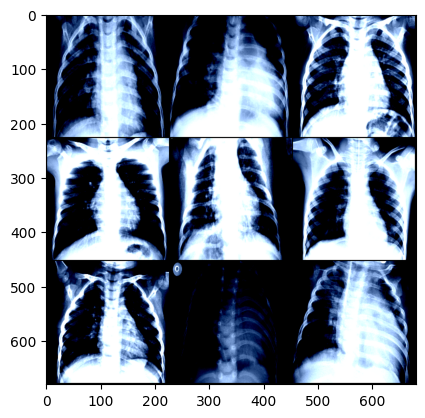

In [5]:
plotExamples(train_loader)

## Hyperparameter Tuning with Ray Tune

In [6]:
# setting scaling and run config
scaling_config = ScalingConfig(
    num_workers=1, use_gpu=True
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="val_BinaryAccuracy",
        checkpoint_score_order="max",
    ),
)

In [7]:
# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

In [8]:
results = tuning(ray_trainer, search_space, num_samples=NUM_SAMPLES, num_epochs=EPOCHS)

(TorchTrainer pid=509968) Started distributed worker processes: 
(TorchTrainer pid=509968) - (ip=10.42.19.63, pid=510140) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=510140) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=510140) [W Utils.hpp:135] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function getCvarInt)
(RayTrainWorker pid=510140) [rank: 0] Seed set to 42
(RayTrainWorker pid=510140) GPU available: True (cuda), used: True
(RayTrainWorker pid=510140) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=510140) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=510140) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=510140) [rank: 0] Seed set to 42
(RayTrainWorker pid=510140) Missing logger folder: /tf/logs/simpleCNN/tuning
(RayTrainWorker pid=510140) 2024-05-15 15:04:11.996344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This Tensor

In [9]:
best_result = results.get_best_result(metric="val_BinaryAccuracy", mode="max")
best_config = best_result.config  # Get best trial's hyperparameters
print(best_config)
#best_logdir = best_result.path  # Get best trial's result directory
#best_checkpoint = best_result.checkpoint  # Get best trial's best checkpoint
best_metrics = best_result.metrics  # Get best trial's last results
print(best_metrics)
best_result_df = best_result.metrics_dataframe  # Get best result as pandas dataframe

{'train_loop_config': {'reproducibility_active': True, 'epochs': 50, 'lr': 0.00035213424594870914, 'batch_size': 32, 'loss': 'CrossEntropyLoss', 'dropout': 0.5}}
{'Traning loss': 0.006649533286690712, 'Validation loss': 0.0829707458615303, 'val_BinaryPrecision': 0.9870466589927673, 'val_BinaryRecall': 0.9844961166381836, 'val_BinaryF1Score': 0.9857697486877441, 'val_BinaryAccuracy': 0.9789674878120422, 'train_BinaryPrecision': 0.9942159652709961, 'train_BinaryRecall': 0.995175302028656, 'train_BinaryF1Score': 0.9946953654289246, 'train_BinaryAccuracy': 0.9921165704727173, 'epoch': 13, 'step': 1834, 'timestamp': 1715786632, 'checkpoint_dir_name': 'checkpoint_000013', 'should_checkpoint': True, 'done': True, 'training_iteration': 14, 'trial_id': '5c31b_00011', 'date': '2024-05-15_15-23-52', 'time_this_iter_s': 17.68561363220215, 'time_total_s': 263.1824162006378, 'pid': 522177, 'hostname': 'briwil-3-7464fdcdc-z9tqq', 'node_ip': '10.42.19.63', 'config': {'train_loop_config': {'reproducibi

In [10]:
print(best_config['train_loop_config'])

{'reproducibility_active': True, 'epochs': 50, 'lr': 0.00035213424594870914, 'batch_size': 32, 'loss': 'CrossEntropyLoss', 'dropout': 0.5}


## Running a CNN with the best found hyperparams

In [11]:
set_reproducibility(42)

Seed set to 42


In [12]:
#best_config = {'train_loop_config': {'reproducibility_active': True, 'epochs': 50, 'lr': 0.00035213424594870914, 'batch_size': 32, 'loss': 'CrossEntropyLoss', 'dropout': 0.5}}

In [13]:
train_loader, val_loader, test_loader = loadData(dataDir="/Project/chest_xray", numWorkers=7, batchSize=best_config['train_loop_config']["batch_size"])

In [14]:
early_stopping = L.pytorch.callbacks.EarlyStopping(monitor='Validation loss', patience=3, min_delta=1e-6)
checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath='pneumonia_model/', monitor="val_BinaryAccuracy", mode='max')
callbacks = [early_stopping, checkpoint]
logger = TensorBoardLogger("/tf/logs/",
                           name=f"simpleCNN/{'augment' if USE_AUGMENT else 'original'}",
                           )

In [15]:
trainer = L.Trainer(
    accelerator = 'auto',
    devices=1,
    logger=logger,
    max_epochs=EPOCHS, 
    callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
cnn = ConvNet(num_classes=2, dropout=best_config['train_loop_config']['dropout'])
classifier = Classificator(cnn, CLASS_LABELS, best_config['train_loop_config'], NUM_CLASSES)
torch.set_float32_matmul_precision('medium')
trainer.fit(classifier,train_dataloaders=train_loader,val_dataloaders=val_loader)

Missing logger folder: /tf/logs/simpleCNN/original
2024-05-15 15:35:40.019462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                  | Params
----------------------------------------------------------------
0 | CNN                   | ConvNet               | 12.0 M
1 | loss                  | CrossEntropyLoss      | 0     
2 | val_confusion_matrix  | BinaryConfusionMatrix | 0     
3 | test_confusion_matrix | BinaryConfusionMatrix | 0     
4 | train_metrics         | MetricCollection      | 0     
5 | valid_metrics         | MetricCollection      | 0     
6 | test_metrics          | MetricCollection      | 0     
-------------------------------------------------

Epoch 0: 100%|██████████| 131/131 [00:13<00:00,  9.60it/s, v_num=0, Traning loss=0.0717]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 131/131 [00:13<00:00,  9.70it/s, v_num=0, Traning loss=0.177, Validation loss=0.120] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 131/131 [00:13<00:00,  9.67it/s, v_num=0, Traning loss=0.257, Validation loss=0.110] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 131/131 [00:13<00:00,  9.69it/s, v_num=0, Traning loss=0.239, Validation loss=0.0902]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 131/131 [00:13<00:00,  9.64it/s, v_num=0, Traning loss=0.00566, Validation loss=0.107]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 131/131 [00:13<00:00,  9.63it/s, v_num=0, Traning loss=0.139, Validation loss=0.100]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 131/131 [00:17<00:00,  7.70it/s, v_num=0, Tra

## Testing final Model

In [17]:
trainer.test(model = classifier, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test loss         │    1.0722087621688843     │
│    test_BinaryAccuracy    │    0.7083333134651184     │
│    test_BinaryF1Score     │    0.8108108043670654     │
│   test_BinaryPrecision    │    0.6818181872367859     │
│     test_BinaryRecall     │            1.0            │
└───────────────────────────┴───────────────────────────┘

[{'Test loss': 1.0722087621688843,
  'test_BinaryPrecision': 0.6818181872367859,
  'test_BinaryRecall': 1.0,
  'test_BinaryF1Score': 0.8108108043670654,
  'test_BinaryAccuracy': 0.7083333134651184}]